<a href="https://colab.research.google.com/github/mdalery/NonLinearReducedBasis/blob/main/maxime/Laplace_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py-pde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.9/277.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pde import CartesianGrid, solve_laplace_equation

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Input layer: 2 input features (x, y)
        self.fc2 = nn.Linear(20, 50)  # Hidden layer
        self.fc3 = nn.Linear(50, 50)  # Hidden layer
        self.fc4 = nn.Linear(50, 20)  # Hidden layer
        self.fc5 = nn.Linear(20, 1)  # Output layer: 1 output (solution u)

    def forward(self, x):
        x = nn.functional.silu(self.fc1(x))
        x = nn.functional.silu(self.fc2(x))
        x = nn.functional.silu(self.fc3(x))
        x = nn.functional.silu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
def train_PINN(model, num_epochs=100, lr=0.001):
    num_epochs = num_epochs * 1000
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Calculate the boundary loss
        boundary_loss = torch.mean((model(inputs_boundary) - boundary_condition(xinputs_boundary, yinputs_boundary))**2)

        # Calculate the interior loss
        outputs_interior = model(inputs_interior)
        grad = torch.autograd.grad(outputs_interior, inputs_interior, grad_outputs=torch.ones_like(outputs_interior), allow_unused=True, create_graph=True, retain_graph=True)[0]
        dxx  = torch.autograd.grad(grad[:, 0], inputs_interior, grad_outputs=torch.ones_like(grad[:, 0]), retain_graph=True)[0][:, 0]
        dyy  = torch.autograd.grad(grad[:, 1], inputs_interior, grad_outputs=torch.ones_like(grad[:, 1]))[0][:, 1]
        laplacian = dxx + dyy
        interior_loss = torch.mean(laplacian**2)

        # Total loss
        loss = 0.2*boundary_loss + 0.8*interior_loss

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch//1000}, Loss: {loss.item()}")

In [ ]:
def boundary_condition(x, y):
        return torch.sin(2*np.pi*x) + torch.sin(2*torch.pi*y)

# DATALOADER ?

In [ ]:
num_interior_points = 512
inputs_interior = torch.rand(num_interior_points, 2, requires_grad = True)

num_boundary_points = 32

xinputs_boundary_left = torch.rand(num_boundary_points, 1)
yinputs_boundary_left = torch.zeros(num_boundary_points).view(-1, 1)

xinputs_boundary_right = torch.rand(num_boundary_points, 1)
yinputs_boundary_right = torch.ones(num_boundary_points).view(-1, 1)

xinputs_boundary_down = torch.zeros(num_boundary_points).view(-1, 1)
yinputs_boundary_down = torch.rand(num_boundary_points, 1)

xinputs_boundary_up = torch.ones(num_boundary_points).view(-1, 1)
yinputs_boundary_up = torch.rand(num_boundary_points, 1)

xinputs_boundary = torch.cat([xinputs_boundary_left, xinputs_boundary_right, xinputs_boundary_up, xinputs_boundary_down], 0)
yinputs_boundary = torch.cat([yinputs_boundary_left, yinputs_boundary_right, yinputs_boundary_up, yinputs_boundary_down], 0)

inputs_boundary = torch.cat([xinputs_boundary, yinputs_boundary], 1)

In [ ]:
#model = PINN()

train_PINN(model, num_epochs = 300, lr = 0.001)

Epoch 0, Loss: 0.10525999218225479
Epoch 1, Loss: 0.10525999218225479
Epoch 2, Loss: 0.10525999218225479
Epoch 3, Loss: 0.10525999218225479
Epoch 4, Loss: 0.10525999218225479
Epoch 5, Loss: 0.10525999218225479
Epoch 6, Loss: 0.10525999218225479
Epoch 7, Loss: 0.10525999218225479
Epoch 8, Loss: 0.10525999218225479
Epoch 9, Loss: 0.10525999218225479
Epoch 10, Loss: 0.10525999218225479
Epoch 11, Loss: 0.10525999218225479
Epoch 12, Loss: 0.10525999218225479
Epoch 13, Loss: 0.10525999218225479
Epoch 14, Loss: 0.10525999218225479
Epoch 15, Loss: 0.10525999218225479
Epoch 16, Loss: 0.10525999218225479
Epoch 17, Loss: 0.10526000708341599
Epoch 18, Loss: 0.10525999218225479
Epoch 19, Loss: 0.10525999218225479
Epoch 20, Loss: 0.10525999218225479
Epoch 21, Loss: 0.10526000708341599
Epoch 22, Loss: 0.10525999218225479
Epoch 23, Loss: 0.10525999218225479
Epoch 24, Loss: 0.10525999218225479
Epoch 25, Loss: 0.10525999218225479
Epoch 26, Loss: 0.10525999218225479
Epoch 27, Loss: 0.10525999218225479
Ep

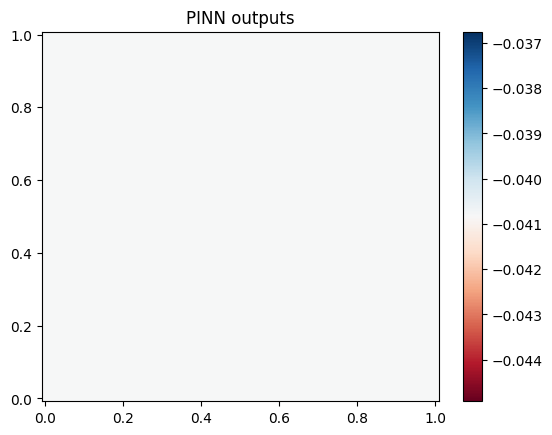

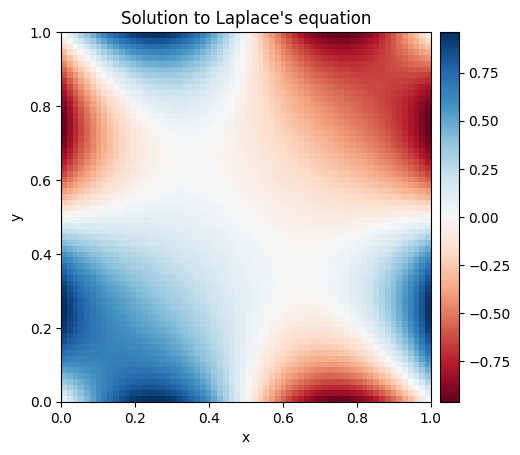

In [ ]:
res = 64

# PINN
inputs = torch.Tensor([ x for x in product(np.linspace(0.0, 1.0, res), np.linspace(0.0, 1.0, res)) ])
outputs = model(inputs).cpu().detach().numpy().reshape((res, res))

y, x = np.meshgrid(np.linspace(0.0, 1.0, res), np.linspace(0.0, 1.0, res))
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, outputs, cmap = 'RdBu')
ax.set_title('PINN outputs')
fig.colorbar(c, ax=ax)
plt.show()


# py-pde
grid = CartesianGrid([[0.0, 1.0]] * 2, 64)
bcs = [{"value": "sin(2*pi*y)"}, {"value": "sin(2*pi*x)"}]
ans = solve_laplace_equation(grid, bcs)
ans.plot(cmap = 'RdBu')